# Ensemble Learning
Group Challenge

***
by: Paul Bédier, Lukasz Pszenny, Lasse Schmidt

within: MS Data Sciences & Business Analytics

at: CentraleSupélec & ESSEC Business School
***

### 1. Import Packages

In [ ]:
from importlib import reload
reload(prepData)

In [1]:
# import own scripts
import util.preprocess_data as prepData

In [2]:
# parse & handle data
import csv
import numpy as np
import pandas as pd
from PIL import Image

# modeling tools
from sklearn.feature_selection import f_regression
from sklearn.model_selection import train_test_split, KFold
from sklearn.pipeline import Pipeline

# models
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor

# evaluation
from sklearn.metrics import ConfusionMatrixDisplay, r2_score

# visualization
from matplotlib import cm
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
# set matplotlib and seaborn settings for nicer plots
%matplotlib inline

SMALL_SIZE = 6
MEDIUM_SIZE = 8
BIGGER_SIZE = 10

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=BIGGER_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=MEDIUM_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

### 2. Retrieve Data

In [4]:
# Retrieve data (including geographical dataframes); can take up to 1min
airbnb, lvl1, lvl2, lvl3, lvl4 = prepData.load_data()

In [5]:
# perform train test split
airbnb_train, airbnb_test = train_test_split(airbnb, test_size = 0.2)

# validate what happened
print(airbnb.shape)
print(airbnb_train.shape)
print(airbnb_test.shape)

(48895, 61)
(39116, 61)
(9779, 61)


In [7]:
# which columns we want to drop (see notebook 1 on feature selection -- may need to change / review this)
drop_cols = ["name", "host_id", "geometry", "room_type", "last_review", "last_review_recency",
             "lvl1_GeoID", "lvl1_name", "lvl2_GeoID", "lvl2_name", "lvl3_GeoID", "lvl3_name",
             "lvl4_GeoID", "lvl4_name", "lvl1_Pop_20", "lvl1_Pop_Ch", "lvl1_HUnits_Ch", "lvl1_VacHU_20P",
             "lvl2_listings_count", "lvl2_listings_count_norm", "lvl3_Pop_Ch", "lvl3_HH2E", "lvl3_MnHHIncE",
             "lvl4_Pop_20", "lvl2_target_m", "lvl3_target_m", "lvl2_Pop_Ch", "lvl3_Inc_RtrmtP"]

# split data
X_train, y_train = prepData.split_frame(airbnb_train)
X_test , y_test  = prepData.split_frame(airbnb_test)

# create preprocessing pipeline
prep_pipe = prepData.PreprocessingPipeline(lambda_type = "sigmoid", min_listings = 0,
                                           lvl1 = lvl1, lvl2 = lvl2, lvl3 = lvl3, lvl4 = lvl4,
                                           drop_cols = drop_cols)


# fit and transform train & test data
prep_pipe.fit(X_train, y_train)
X_train = prep_pipe.transform(X_train)
X_test  = prep_pipe.transform(X_test)

# validate
print(X_train.shape, y_train.shape)
print(X_test.shape,  y_test.shape)

(39116, 41) (39116,)
(9779, 41) (9779,)


### 3. Evaluate Data

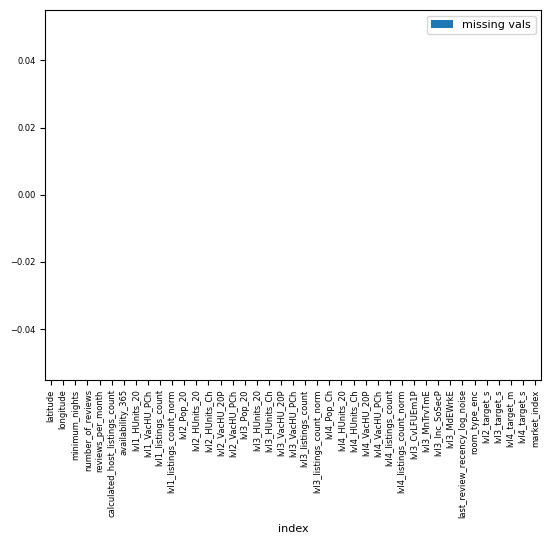

In [8]:
# train data must have no missing values
prepData.show_missing_vals(X_train)

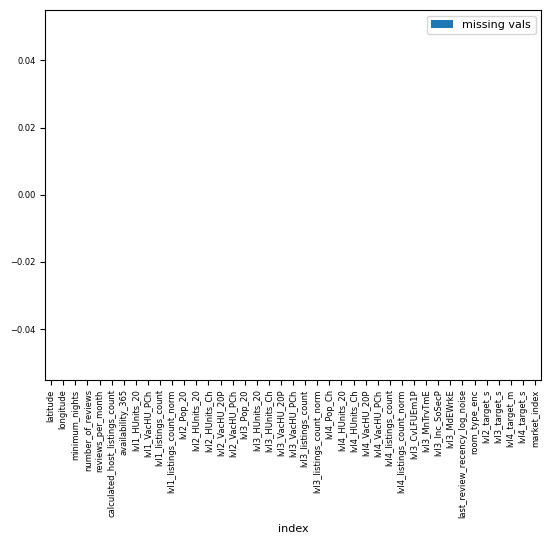

In [9]:
# test data must have no missing values
prepData.show_missing_vals(X_test)

### 4. Model Training

During feature engineering we have created numerous features that are based on the true target values. Even though we carefully designed each feature, the target-encoded features may still lead to overfitting on training data.

Let us first look at the performance of a Baseline XGBoost Model (no cross-validation, no hyperparameter tuning) and how important each feature is for prediction.

In [10]:
# basic XGBoost (best to use for RFECV as very short runtime)
clf = XGBRegressor(n_estimators = 100, max_depth = 7, eta = 0.1, subsample = 0.7, colsample_bytree = 0.8)
clf.fit(X_train, y_train)

# predict train
y_pred = clf.predict(X_train)
# compute R^2 metric
r2_train = r2_score(y_train, y_pred)

# predict test
y_pred = clf.predict(X_test)
# compute R^2 metric
r2_test = r2_score(y_test, y_pred)

print(f"R squared train: {r2_train}")
print(f"R squared test : {r2_test}")

R squared train: 0.9843134646844397
R squared test : 0.13276075383475894


Text(0.5, 1.0, 'Feature importance')

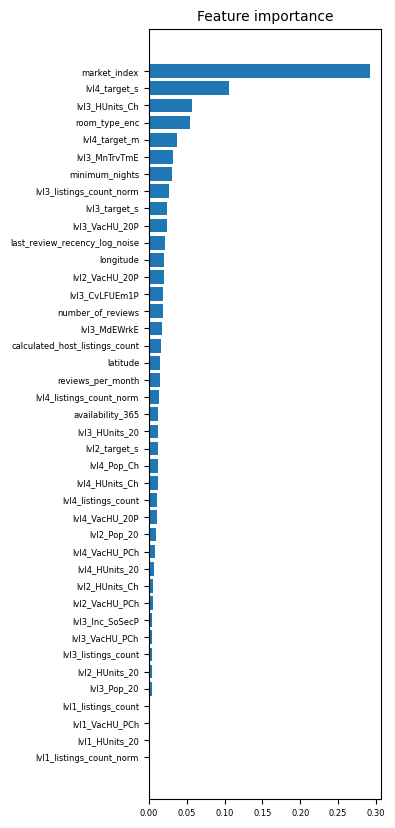

In [11]:
# look at feature importance of basic XGBoost
sorted_idx = clf.feature_importances_.argsort()

fig, ax = plt.subplots(figsize = (3, 10))
ax.barh(X_train.columns[sorted_idx], clf.feature_importances_[sorted_idx])
plt.title("Feature importance")